In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dadosv2(train_data, test_data, test_size=0.2, random_state=42):
    # Load data from CSV file
    scaler = StandardScaler()

    train_data = pd.read_csv(train_data)
    val_data = pd.read_csv(test_data)

    # Split data into features (X) and targets (y) ("hysteresis")
    X = train_data.drop(['hysteresis', 'joule'], axis=1)
    y = train_data[['hysteresis', 'joule']]

    # Perform train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_test = val_data.drop(['hysteresis', 'joule'], axis=1)
    y_test = val_data[['hysteresis', 'joule']]

    X_train = scaler.fit_transform(X_train.values)
    X_val = scaler.transform(X_val.values)
    X_test = scaler.transform(X_test.values)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

In [ ]:
import matplotlib.pyplot as plt
import torch

def plot_comparacao(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    plt.figure(figsize=(8, 6))

    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)

    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Linha de Referência')

    plt.xlabel('Valores previstos')
    plt.ylabel('valores Reais')
    plt.title('Comparação entre Valores Reais e Valores Previstos')
    plt.legend()


    plt.show()


import matplotlib.pyplot as plt

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RegressionModel, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim if _ == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
from torch import tensor
from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna


def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)
def create_train_model(input_dim, output_dim, X_train, y_train, X_val, y_val):
    def train_model(trial):

        hidden_dim = trial.suggest_int('hidden_dim', 16, 32)
        num_layers = trial.suggest_int('num_layers', 5, 30)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 2e-4, log=True)
        batch_size = trial.suggest_int('batch_size', 512, 512)

        model = RegressionModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        X_train_device = X_train.to(device)
        y_train_device = y_train.to(device)
        X_val_device = X_val.to(device)
        y_val_device = y_val.to(device)

        model.train()
        for epoch in range(100):
            permutation = torch.randperm(X_train.size()[0]).to(device)
            for i in range(0, X_train.size()[0], batch_size):
                optimizer.zero_grad()
                indices = permutation[i:i + batch_size]
                batch_x, batch_y = X_train[indices], y_train[indices]

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = mean_squared_error(y_val.cpu().numpy(), val_outputs.cpu().numpy())
            plot_comparacao(y_val, val_outputs)


        return val_loss

    return train_model

def evaluate(model,val_set,val_target):
    criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_set)
        val_loss = criterion(val_outputs, val_target)
        print(f'Val_Loss: {val_loss}')


def test(model, data):
    model.to(device)  # Ensure the model is on the same device
    model.eval()
    criterion_MSE = nn.MSELoss()
    criterion_MAE = nn.L1Loss()
    criterion_MAPE = MeanAbsolutePercentageError().to(device)  # Ensure criterion_MAPE is on the same device

    with torch.no_grad():
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        predicted = model(inputs)  # No need to .to(device) again, already on device
        test_loss_MSE = criterion_MSE(predicted, targets)
        test_loss_MAE = criterion_MAE(predicted, targets)
        test_loss_MAPE = criterion_MAPE(predicted, targets)

        print(f'MSE Test Loss: {test_loss_MSE.item():.4f}')
        print(f'MAE Test Loss: {test_loss_MAE.item():.4f}')
        print(f'MAPE Test Loss: {test_loss_MAPE.item():.4f}')

    return predicted

In [ ]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/Nabla'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')


In [ ]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [ ]:
histeresis_train_tensor = [pair[0].item() for pair in y_train_tensor]
histeresis_train_tensor = torch.tensor(histeresis_train_tensor, dtype=torch.float32).to(device)
histeresis_train_tensor = histeresis_train_tensor.unsqueeze(1)

joule_train_tensor = [pair[1].item() for pair in y_train_tensor]
joule_train_tensor = torch.tensor(joule_train_tensor, dtype=torch.float32).to(device)
joule_train_tensor = joule_train_tensor.unsqueeze(1)

histeresis_val_tensor = [pair[0].item() for pair in y_val_tensor]
histeresis_val_tensor = torch.tensor(histeresis_val_tensor, dtype=torch.float32).to(device)
histeresis_val_tensor = histeresis_val_tensor.unsqueeze(1)

joule_val_tensor = [pair[1].item() for pair in y_val_tensor]
joule_val_tensor = torch.tensor(joule_val_tensor, dtype=torch.float32).to(device)
joule_val_tensor = joule_val_tensor.unsqueeze(1)

histeresis_test_tensor = [pair[0].item() for pair in y_test_tensor]
histeresis_test_tensor = torch.tensor(histeresis_test_tensor, dtype=torch.float32).to(device)
histeresis_test_tensor = histeresis_test_tensor.unsqueeze(1)

joule_test_tensor = [pair[1].item() for pair in y_test_tensor]
joule_test_tensor = torch.tensor(joule_test_tensor, dtype=torch.float32).to(device)
joule_test_tensor = joule_test_tensor.unsqueeze(1)

[I 2024-06-30 18:20:09,432] A new study created in memory with name: no-name-2c2bc805-d629-4765-ad69-e8276949d46f


11


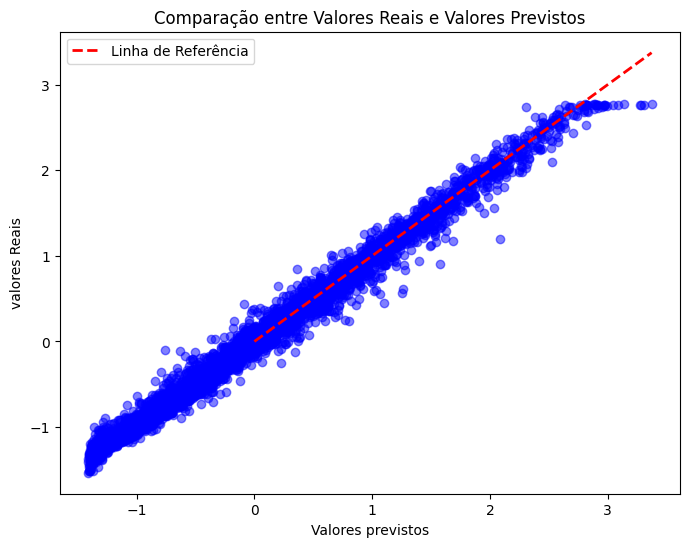

[I 2024-06-30 18:20:38,139] Trial 0 finished with value: 0.013180647045373917 and parameters: {'hidden_dim': 26, 'num_layers': 17, 'learning_rate': 0.00011422361617745015, 'batch_size': 512}. Best is trial 0 with value: 0.013180647045373917.


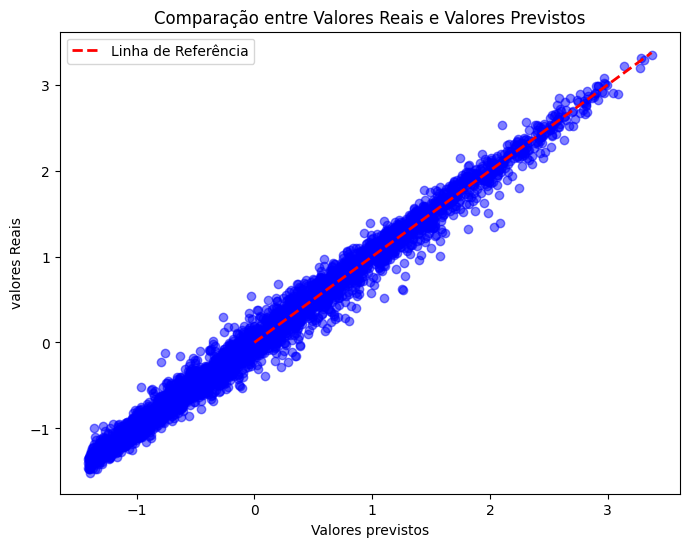

[I 2024-06-30 18:20:56,107] Trial 1 finished with value: 0.013269344344735146 and parameters: {'hidden_dim': 19, 'num_layers': 19, 'learning_rate': 0.000127859453502622, 'batch_size': 512}. Best is trial 0 with value: 0.013180647045373917.


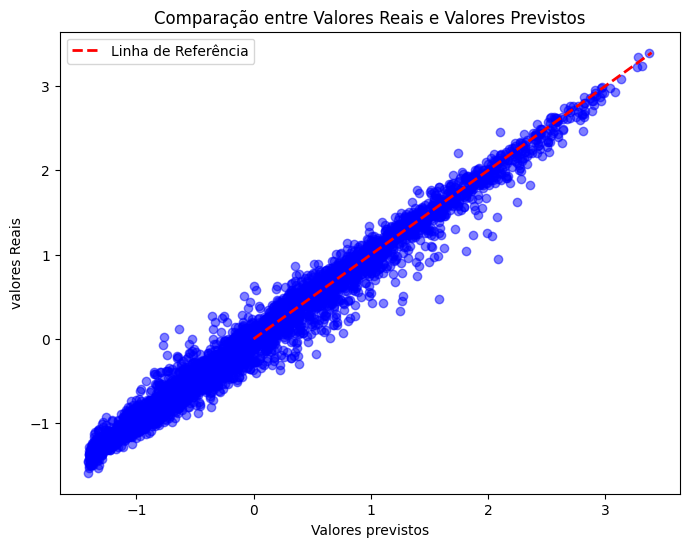

[I 2024-06-30 18:21:12,943] Trial 2 finished with value: 0.02137666940689087 and parameters: {'hidden_dim': 16, 'num_layers': 17, 'learning_rate': 0.00012853880269583844, 'batch_size': 512}. Best is trial 0 with value: 0.013180647045373917.


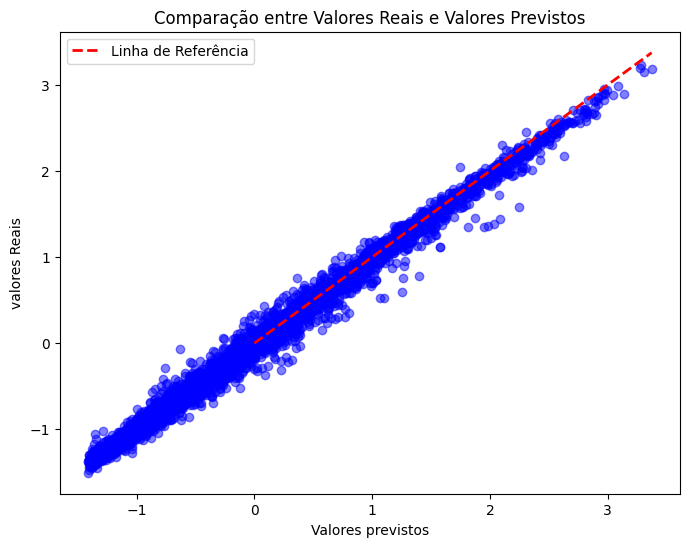

[I 2024-06-30 18:21:27,078] Trial 3 finished with value: 0.010243812575936317 and parameters: {'hidden_dim': 31, 'num_layers': 14, 'learning_rate': 0.00019906284555850238, 'batch_size': 512}. Best is trial 3 with value: 0.010243812575936317.


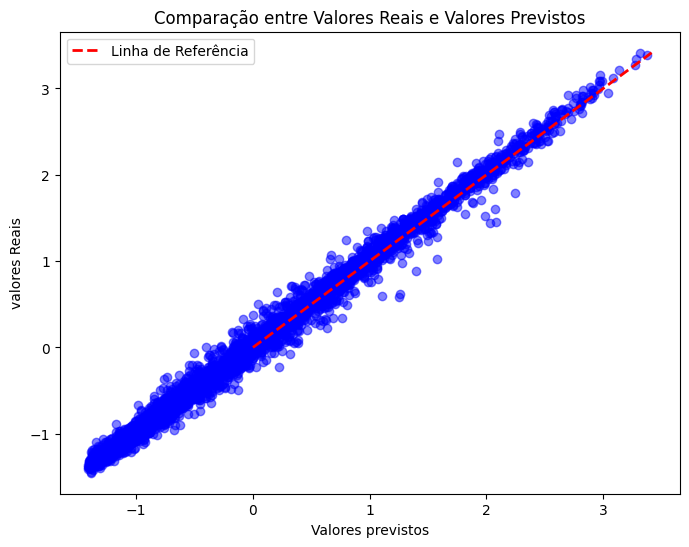

[I 2024-06-30 18:21:41,326] Trial 4 finished with value: 0.009672222658991814 and parameters: {'hidden_dim': 31, 'num_layers': 14, 'learning_rate': 0.00011769569973806636, 'batch_size': 512}. Best is trial 4 with value: 0.009672222658991814.


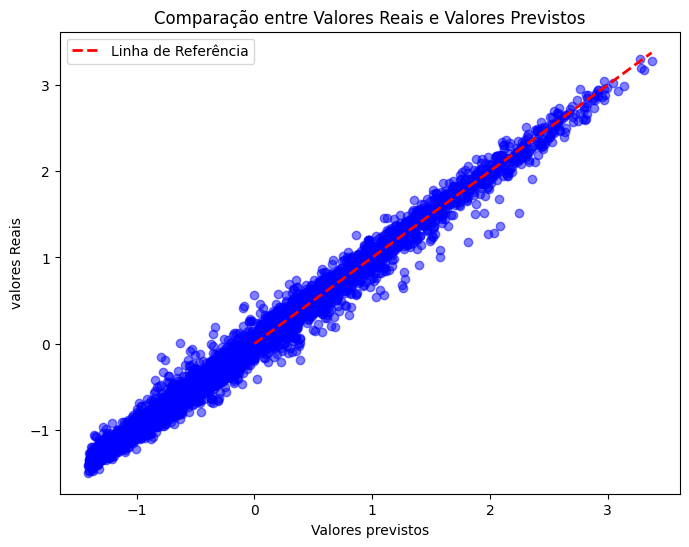

[I 2024-06-30 18:21:53,229] Trial 5 finished with value: 0.013111399486660957 and parameters: {'hidden_dim': 22, 'num_layers': 8, 'learning_rate': 0.00010933285612253383, 'batch_size': 512}. Best is trial 4 with value: 0.009672222658991814.


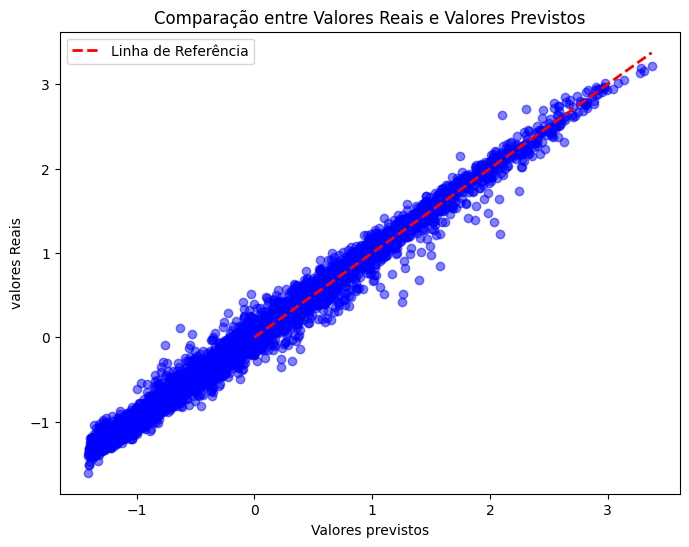

[I 2024-06-30 18:22:10,909] Trial 6 finished with value: 0.014155966229736805 and parameters: {'hidden_dim': 17, 'num_layers': 19, 'learning_rate': 0.00016366383255271975, 'batch_size': 512}. Best is trial 4 with value: 0.009672222658991814.


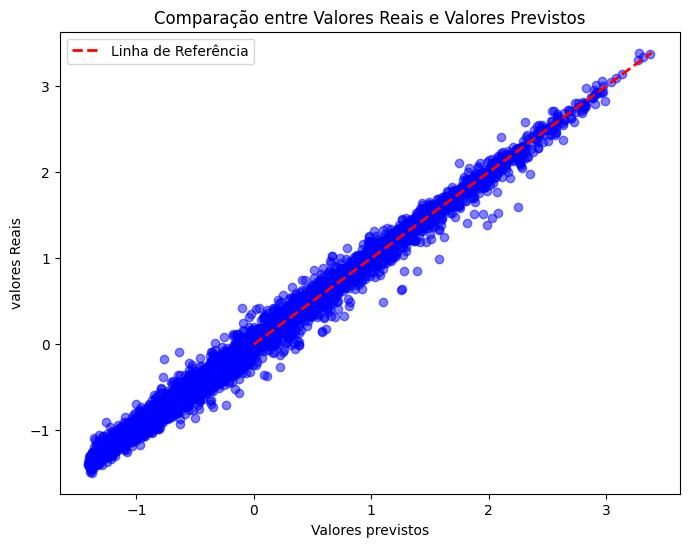

[I 2024-06-30 18:22:20,030] Trial 7 finished with value: 0.010395422577857971 and parameters: {'hidden_dim': 22, 'num_layers': 6, 'learning_rate': 0.00019627866044527234, 'batch_size': 512}. Best is trial 4 with value: 0.009672222658991814.


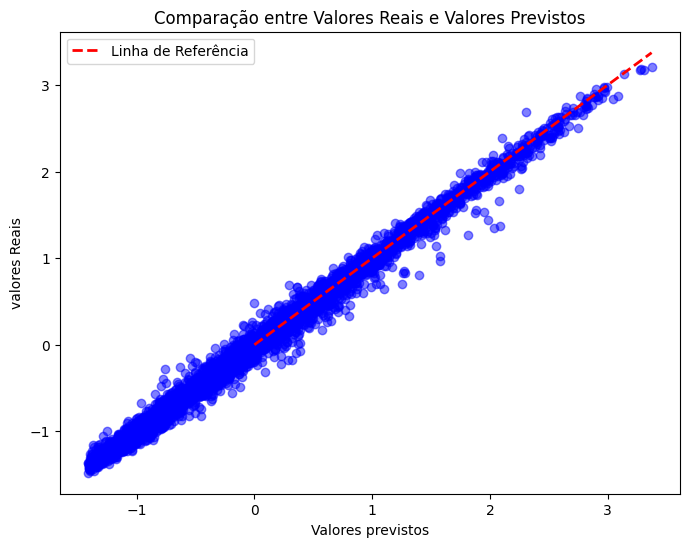

[I 2024-06-30 18:22:32,379] Trial 8 finished with value: 0.009173995815217495 and parameters: {'hidden_dim': 30, 'num_layers': 11, 'learning_rate': 0.0001697128917338975, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


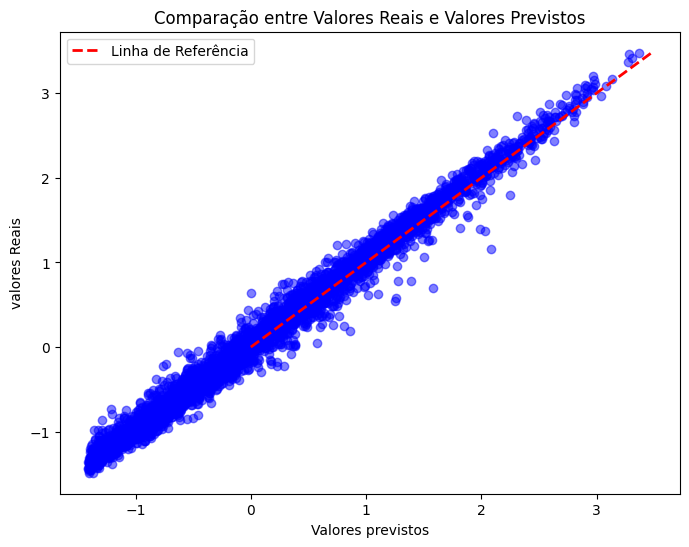

[I 2024-06-30 18:22:43,340] Trial 9 finished with value: 0.015439438633620739 and parameters: {'hidden_dim': 29, 'num_layers': 9, 'learning_rate': 0.00010456574479093697, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


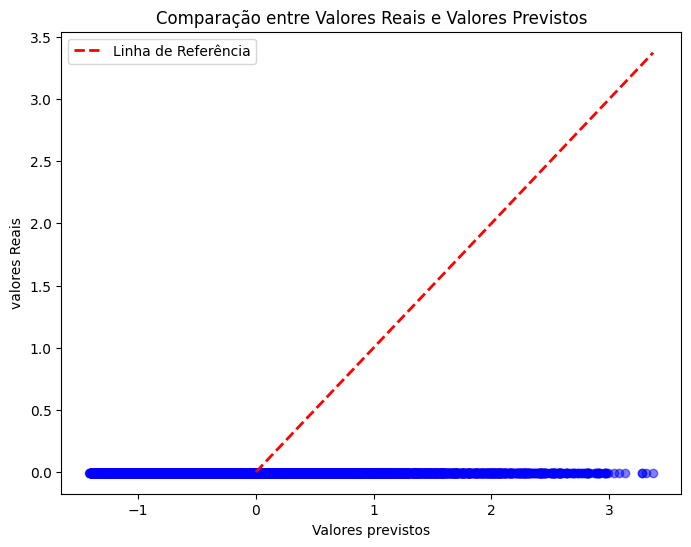

[I 2024-06-30 18:23:06,795] Trial 10 finished with value: 1.019133448600769 and parameters: {'hidden_dim': 27, 'num_layers': 28, 'learning_rate': 0.00016062088897462023, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


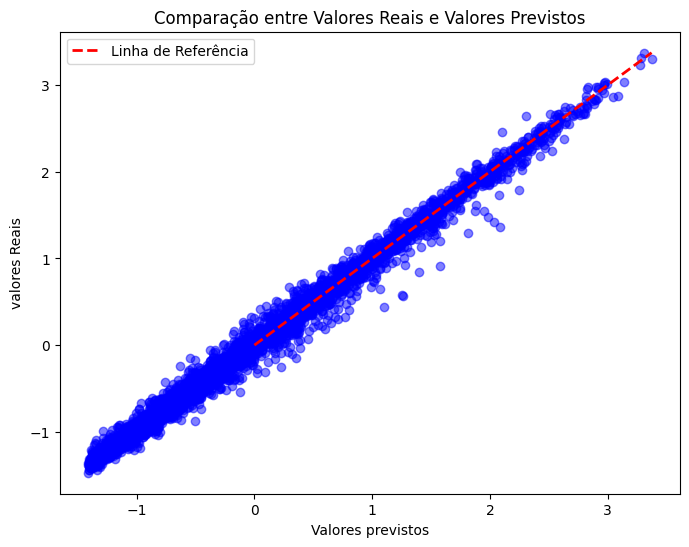

[I 2024-06-30 18:23:19,714] Trial 11 finished with value: 0.00967309158295393 and parameters: {'hidden_dim': 32, 'num_layers': 12, 'learning_rate': 0.00015346892031483286, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


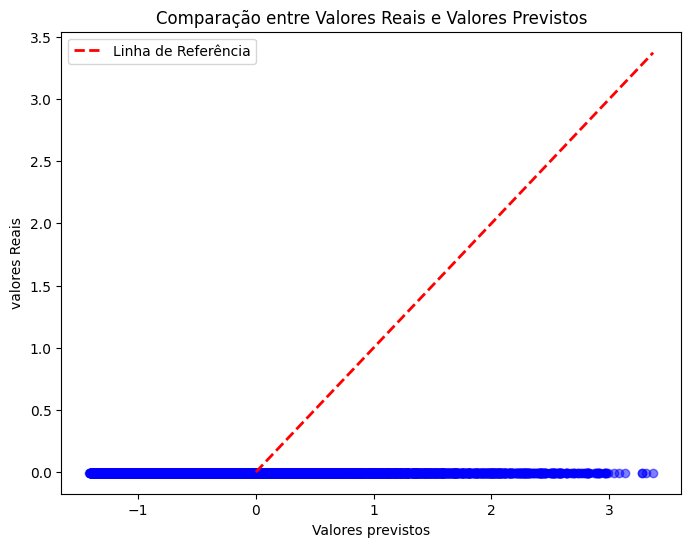

[I 2024-06-30 18:23:42,284] Trial 12 finished with value: 1.0191473960876465 and parameters: {'hidden_dim': 30, 'num_layers': 24, 'learning_rate': 0.00013723887872115766, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


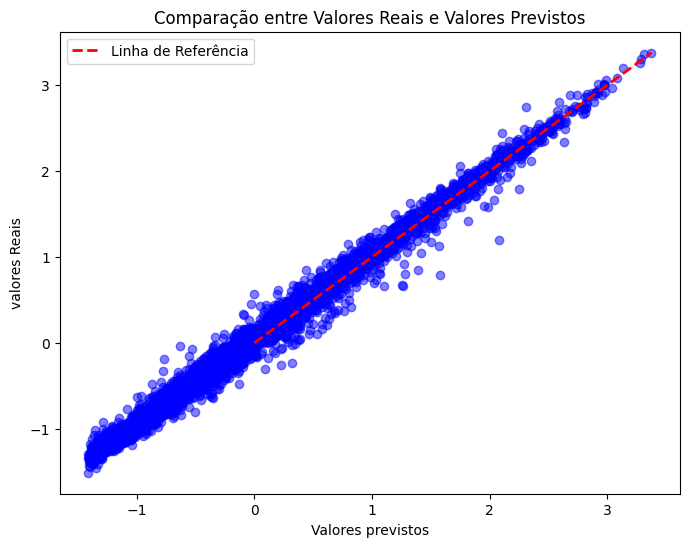

[I 2024-06-30 18:23:55,133] Trial 13 finished with value: 0.012036053463816643 and parameters: {'hidden_dim': 28, 'num_layers': 12, 'learning_rate': 0.0001783550000070312, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


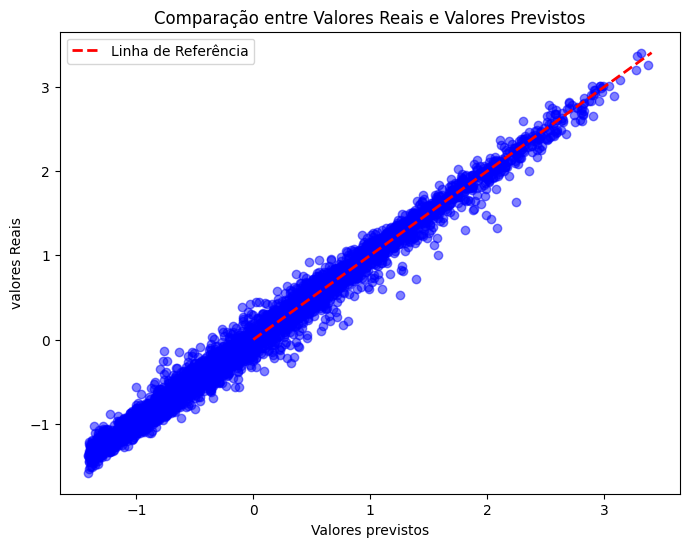

[I 2024-06-30 18:24:03,507] Trial 14 finished with value: 0.013348469510674477 and parameters: {'hidden_dim': 32, 'num_layers': 5, 'learning_rate': 0.00012017993588702569, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


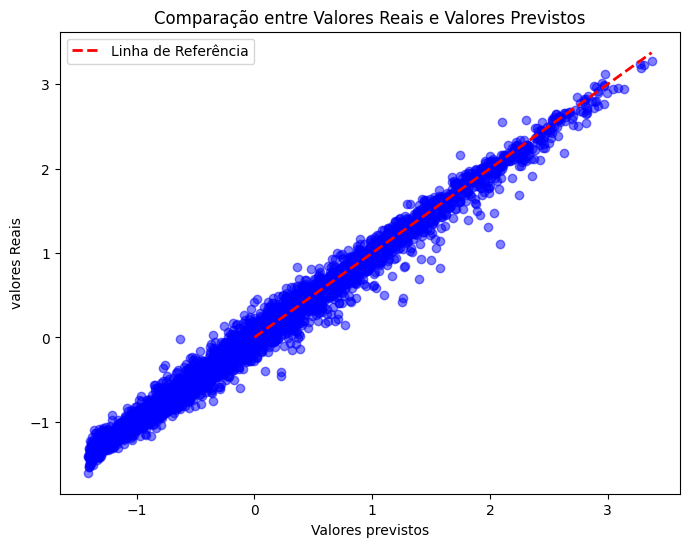

[I 2024-06-30 18:24:17,799] Trial 15 finished with value: 0.013256675563752651 and parameters: {'hidden_dim': 24, 'num_layers': 14, 'learning_rate': 0.00014104706905967242, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


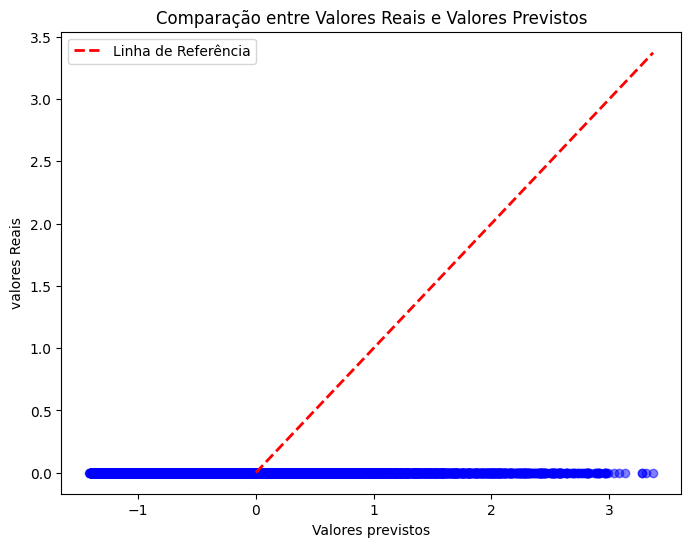

[I 2024-06-30 18:24:37,594] Trial 16 finished with value: 1.0189000368118286 and parameters: {'hidden_dim': 25, 'num_layers': 23, 'learning_rate': 0.0001786491004953213, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


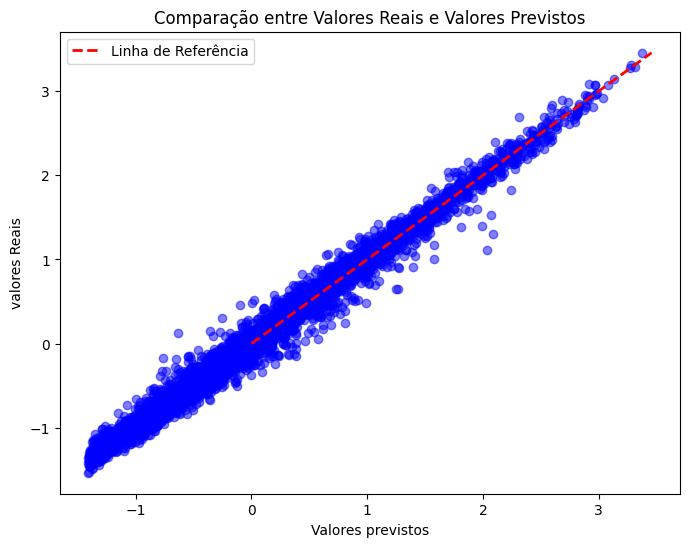

[I 2024-06-30 18:24:49,816] Trial 17 finished with value: 0.014453757554292679 and parameters: {'hidden_dim': 29, 'num_layers': 11, 'learning_rate': 0.00010035733287404166, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


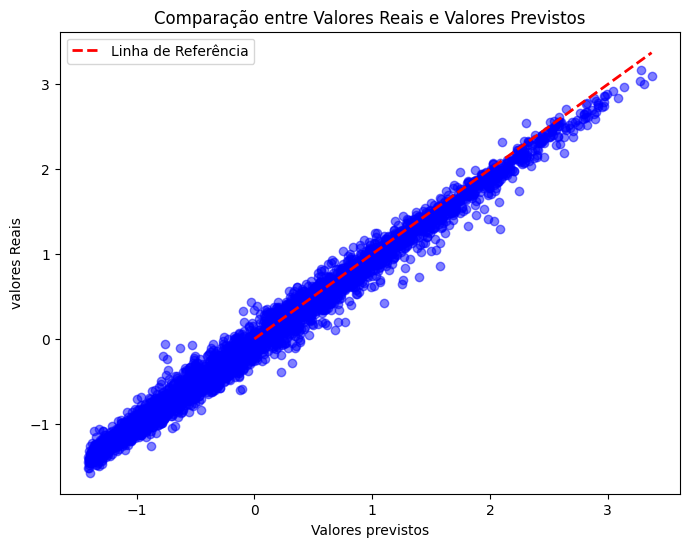

[I 2024-06-30 18:25:04,517] Trial 18 finished with value: 0.014680398628115654 and parameters: {'hidden_dim': 30, 'num_layers': 15, 'learning_rate': 0.0001470273057321789, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


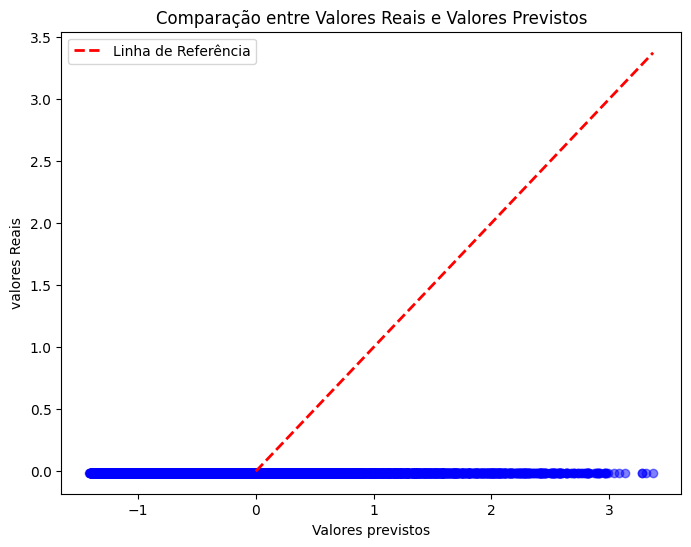

[I 2024-06-30 18:25:25,457] Trial 19 finished with value: 1.0195447206497192 and parameters: {'hidden_dim': 23, 'num_layers': 23, 'learning_rate': 0.00017874583705497181, 'batch_size': 512}. Best is trial 8 with value: 0.009173995815217495.


In [ ]:
input_size = X_train_tensor.shape[1]
print(input_size)

study1 = optuna.create_study(direction='minimize')
train_model = create_train_model(input_size,1,X_train_tensor, histeresis_train_tensor,X_val_tensor,histeresis_val_tensor)
study1.optimize(train_model, n_trials=20)

trial = study1.best_trial

In [ ]:
best_model_h = trial.params

best_model = RegressionModel(X_train_tensor.shape[1], best_model_h['hidden_dim'], 1, best_model_h['num_layers']).to(device)

optimizer = optim.Adam(best_model.parameters(), lr=best_model_h['learning_rate'])

for name, param in best_model.named_parameters():
    print(f"{name}: {param.size()}")

print(best_model)

network.0.weight: torch.Size([30, 11])
network.0.bias: torch.Size([30])
network.2.weight: torch.Size([30, 30])
network.2.bias: torch.Size([30])
network.4.weight: torch.Size([30, 30])
network.4.bias: torch.Size([30])
network.6.weight: torch.Size([30, 30])
network.6.bias: torch.Size([30])
network.8.weight: torch.Size([30, 30])
network.8.bias: torch.Size([30])
network.10.weight: torch.Size([30, 30])
network.10.bias: torch.Size([30])
network.12.weight: torch.Size([30, 30])
network.12.bias: torch.Size([30])
network.14.weight: torch.Size([30, 30])
network.14.bias: torch.Size([30])
network.16.weight: torch.Size([30, 30])
network.16.bias: torch.Size([30])
network.18.weight: torch.Size([30, 30])
network.18.bias: torch.Size([30])
network.20.weight: torch.Size([30, 30])
network.20.bias: torch.Size([30])
network.22.weight: torch.Size([1, 30])
network.22.bias: torch.Size([1])
RegressionModel(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=30, bias=True)
    (1): ReLU()
    (2

In [ ]:
def fine_tune(params,model,num_epochs,optimizer,train_set,target,val_set,val_target):
  criterion = nn.MSELoss()
  model.train()
  for epoch in range(num_epochs):
      permutation = torch.randperm(train_set.size()[0]).to(device)
      for i in range(0, train_set.size()[0], params['batch_size']):
          optimizer.zero_grad()
          indices = permutation[i:i + params['batch_size']]
          batch_x, batch_y = train_set[indices], target[indices]

          outputs = model(batch_x)
          loss = criterion(outputs, batch_y)
          loss.backward()
          optimizer.step()

  model.eval()
  with torch.no_grad():
      val_outputs = model(val_set)
      val_loss = mean_squared_error(val_target.cpu().numpy(), val_outputs.cpu().numpy())

fine_tune(best_model_h,best_model,5000,optimizer,X_train_tensor,histeresis_train_tensor,X_val_tensor,histeresis_val_tensor)
previstos_h = test(best_model.to(device), [X_test_tensor.to(device), histeresis_test_tensor.to(device)])
modeltosave = {'state_dict': best_model.state_dict(),'optimizer':optimizer.state_dict()}
save_model(modeltosave,"nablah_model.pth")
print(previstos_h)

MSE Test Loss: 0.0018
MAE Test Loss: 0.0246
MAPE Test Loss: 0.3413
salvando modelo...
tensor([[-0.4314],
        [-0.4118],
        [-0.2721],
        ...,
        [-0.9423],
        [-1.3771],
        [-1.0791]], device='cuda:0')


In [ ]:
print('Best trial:')
trial = study1.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value: 0.009173995815217495
  Params: 
    hidden_dim: 30
    num_layers: 11
    learning_rate: 0.0001697128917338975
    batch_size: 512


[I 2024-06-30 19:02:04,242] A new study created in memory with name: no-name-52bcc5f6-62fe-492a-9865-a5c84e171fe8


11


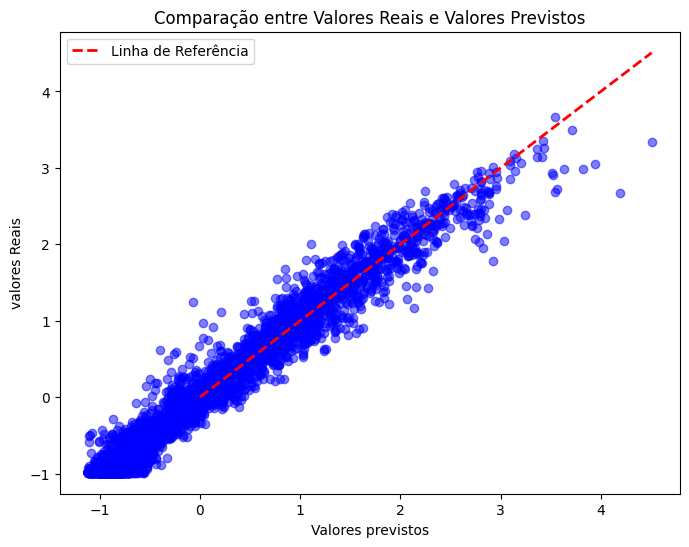

[I 2024-06-30 19:02:29,931] Trial 0 finished with value: 0.03631311655044556 and parameters: {'hidden_dim': 23, 'num_layers': 30, 'learning_rate': 0.00018136815156522335, 'batch_size': 512}. Best is trial 0 with value: 0.03631311655044556.


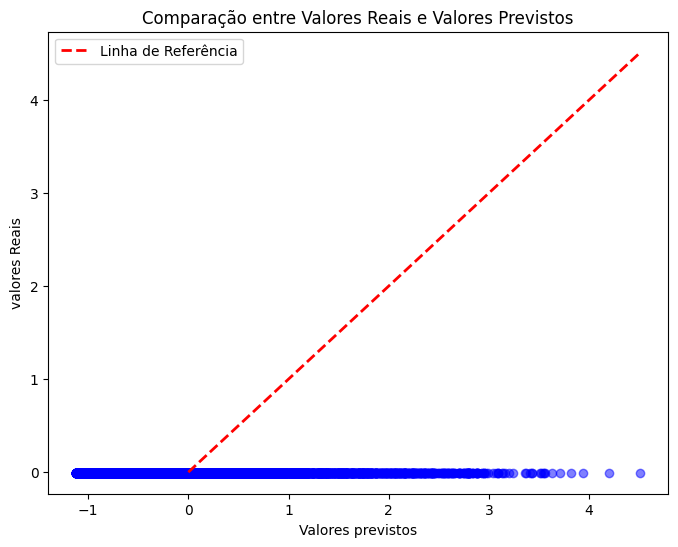

[I 2024-06-30 19:02:53,974] Trial 1 finished with value: 1.0200920104980469 and parameters: {'hidden_dim': 27, 'num_layers': 30, 'learning_rate': 0.000122718465554875, 'batch_size': 512}. Best is trial 0 with value: 0.03631311655044556.


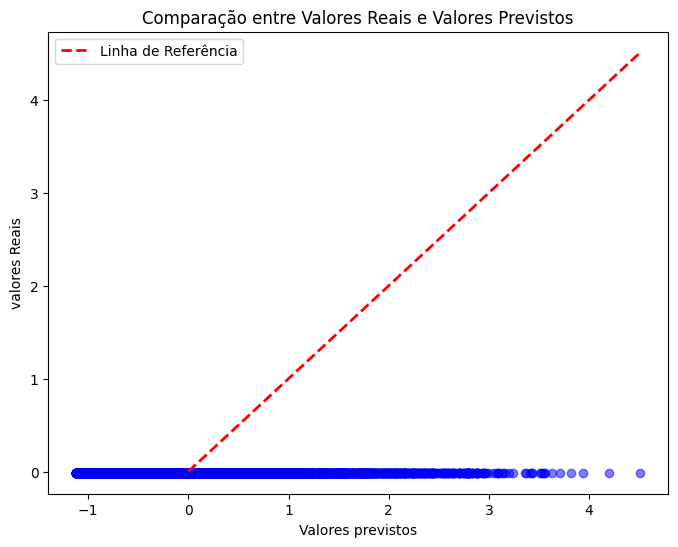

[I 2024-06-30 19:03:18,023] Trial 2 finished with value: 1.0204968452453613 and parameters: {'hidden_dim': 30, 'num_layers': 29, 'learning_rate': 0.00011589519234009047, 'batch_size': 512}. Best is trial 0 with value: 0.03631311655044556.


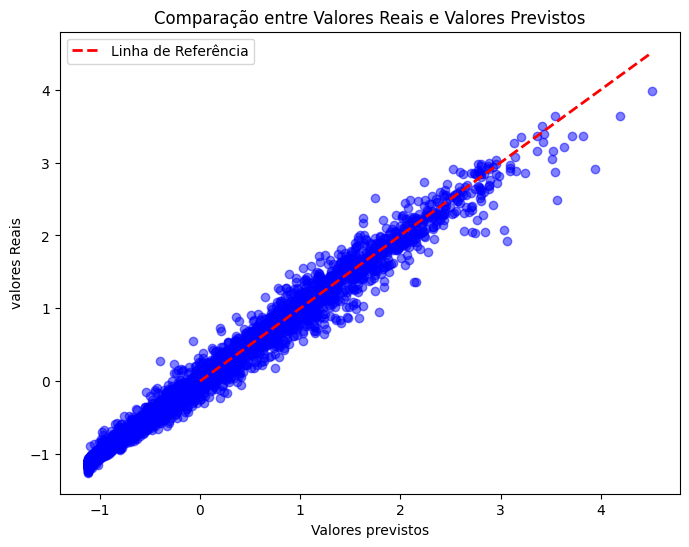

[I 2024-06-30 19:03:29,536] Trial 3 finished with value: 0.017056623473763466 and parameters: {'hidden_dim': 22, 'num_layers': 10, 'learning_rate': 0.00013748068355639537, 'batch_size': 512}. Best is trial 3 with value: 0.017056623473763466.


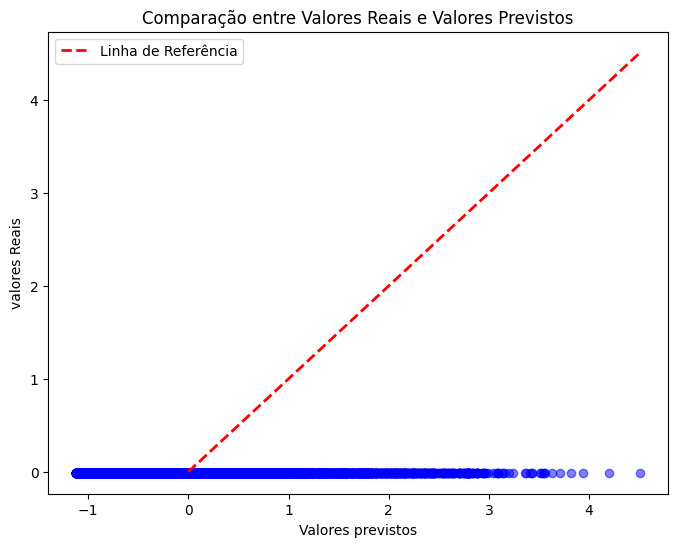

[I 2024-06-30 19:03:49,053] Trial 4 finished with value: 1.0203489065170288 and parameters: {'hidden_dim': 24, 'num_layers': 21, 'learning_rate': 0.00014863920500312767, 'batch_size': 512}. Best is trial 3 with value: 0.017056623473763466.


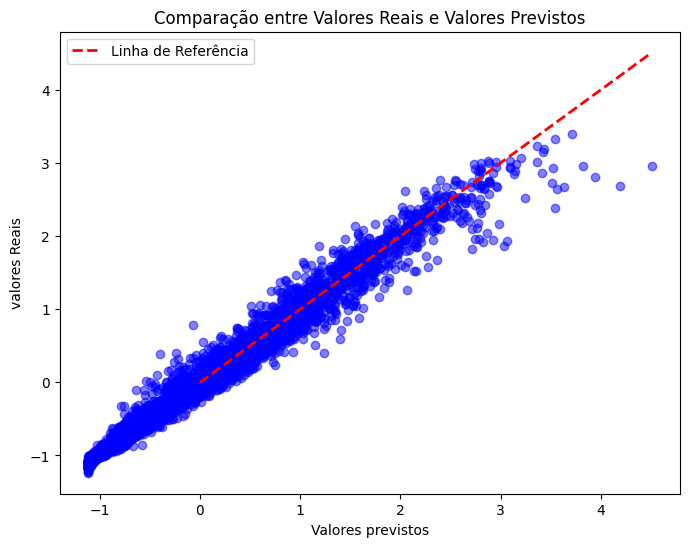

[I 2024-06-30 19:04:07,097] Trial 5 finished with value: 0.02451101876795292 and parameters: {'hidden_dim': 17, 'num_layers': 20, 'learning_rate': 0.00014977592619987309, 'batch_size': 512}. Best is trial 3 with value: 0.017056623473763466.


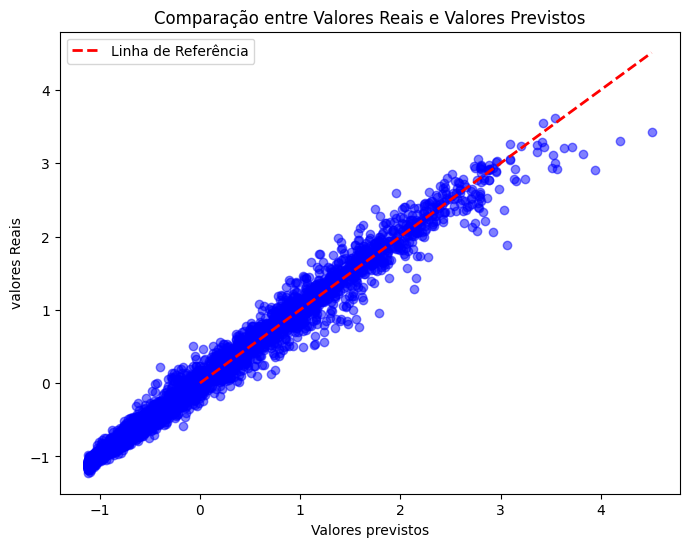

[I 2024-06-30 19:04:17,156] Trial 6 finished with value: 0.017968978732824326 and parameters: {'hidden_dim': 21, 'num_layers': 6, 'learning_rate': 0.00018172983118745818, 'batch_size': 512}. Best is trial 3 with value: 0.017056623473763466.


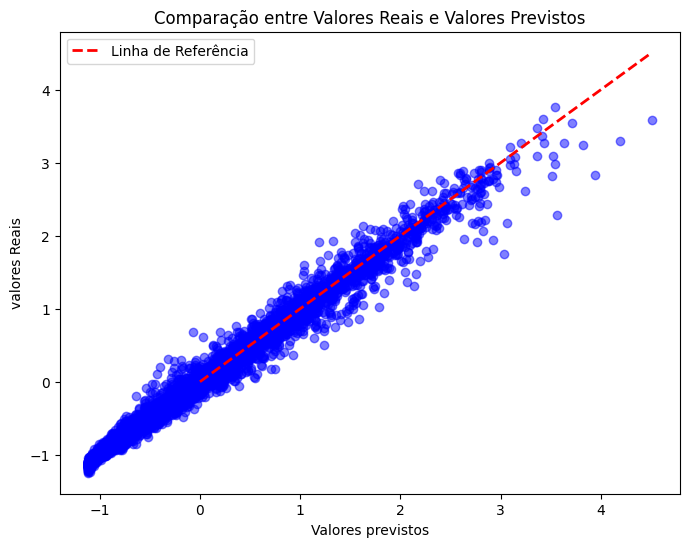

[I 2024-06-30 19:04:34,251] Trial 7 finished with value: 0.01895982399582863 and parameters: {'hidden_dim': 29, 'num_layers': 17, 'learning_rate': 0.00018354515131706586, 'batch_size': 512}. Best is trial 3 with value: 0.017056623473763466.


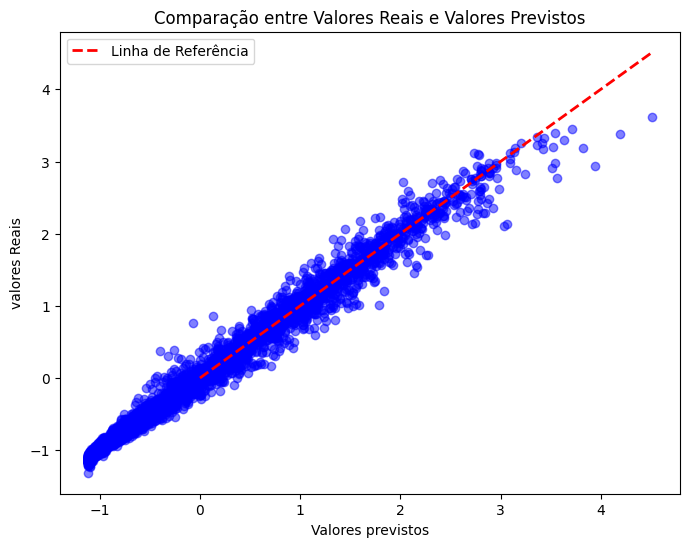

[I 2024-06-30 19:04:42,885] Trial 8 finished with value: 0.0166134275496006 and parameters: {'hidden_dim': 29, 'num_layers': 6, 'learning_rate': 0.00018562473363105655, 'batch_size': 512}. Best is trial 8 with value: 0.0166134275496006.


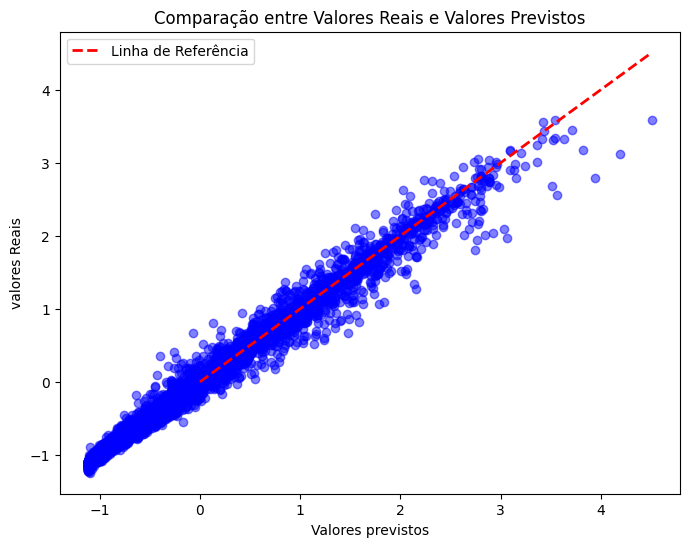

[I 2024-06-30 19:04:57,299] Trial 9 finished with value: 0.019047174602746964 and parameters: {'hidden_dim': 23, 'num_layers': 14, 'learning_rate': 0.0001474009460061844, 'batch_size': 512}. Best is trial 8 with value: 0.0166134275496006.


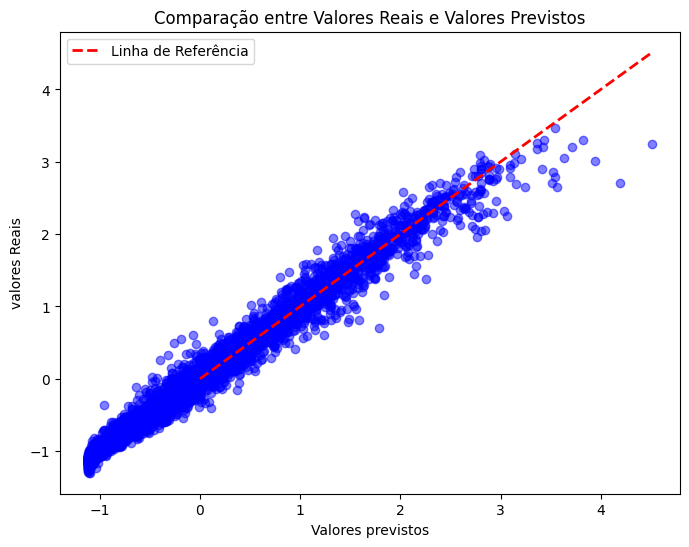

[I 2024-06-30 19:05:05,021] Trial 10 finished with value: 0.023227842524647713 and parameters: {'hidden_dim': 27, 'num_layers': 5, 'learning_rate': 0.00010508130935237276, 'batch_size': 512}. Best is trial 8 with value: 0.0166134275496006.


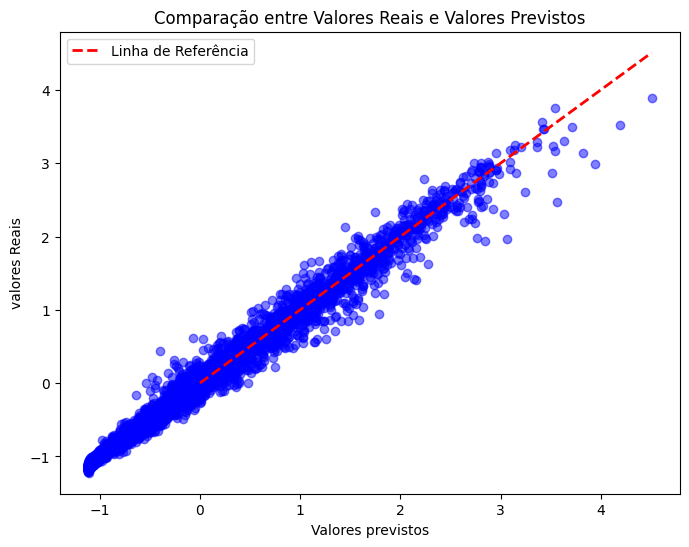

[I 2024-06-30 19:05:16,534] Trial 11 finished with value: 0.017695719376206398 and parameters: {'hidden_dim': 32, 'num_layers': 10, 'learning_rate': 0.0001295745628150026, 'batch_size': 512}. Best is trial 8 with value: 0.0166134275496006.


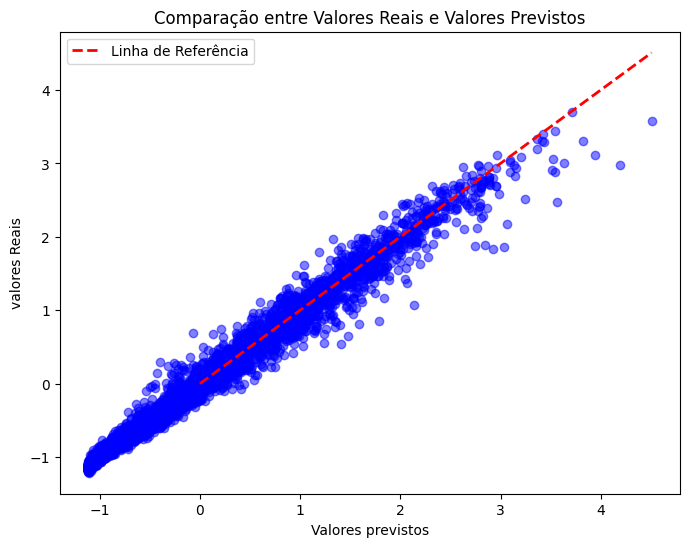

[I 2024-06-30 19:05:28,158] Trial 12 finished with value: 0.020752307027578354 and parameters: {'hidden_dim': 18, 'num_layers': 10, 'learning_rate': 0.00016468313948133468, 'batch_size': 512}. Best is trial 8 with value: 0.0166134275496006.


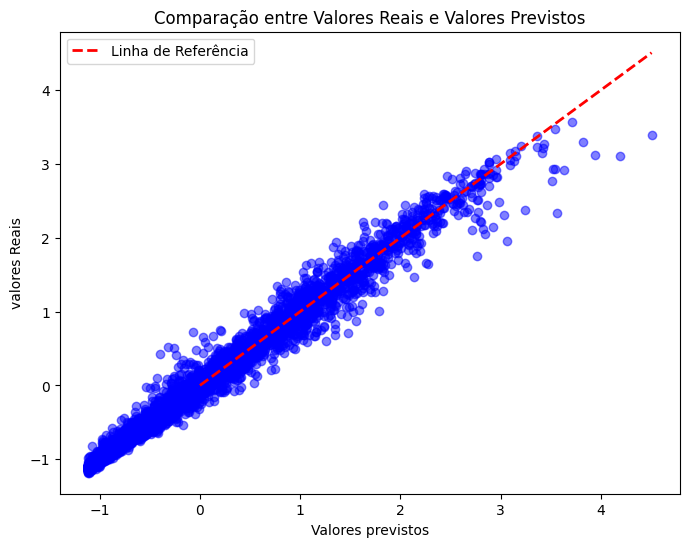

[I 2024-06-30 19:05:39,878] Trial 13 finished with value: 0.020643167197704315 and parameters: {'hidden_dim': 20, 'num_layers': 10, 'learning_rate': 0.00013230350755103764, 'batch_size': 512}. Best is trial 8 with value: 0.0166134275496006.


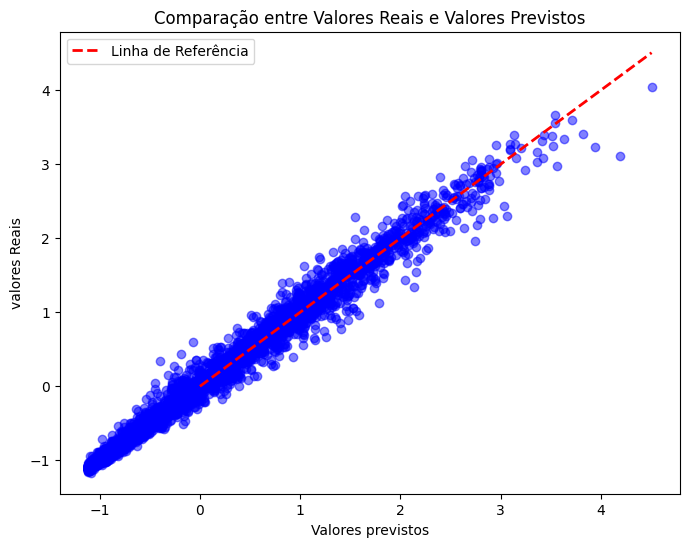

[I 2024-06-30 19:05:49,922] Trial 14 finished with value: 0.015376880764961243 and parameters: {'hidden_dim': 26, 'num_layers': 8, 'learning_rate': 0.00019765098110148635, 'batch_size': 512}. Best is trial 14 with value: 0.015376880764961243.


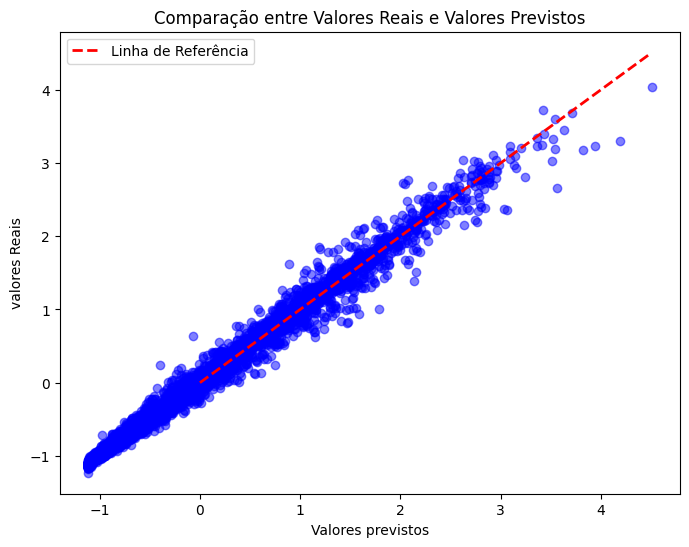

[I 2024-06-30 19:06:04,365] Trial 15 finished with value: 0.013803983107209206 and parameters: {'hidden_dim': 26, 'num_layers': 14, 'learning_rate': 0.0001981005256491448, 'batch_size': 512}. Best is trial 15 with value: 0.013803983107209206.


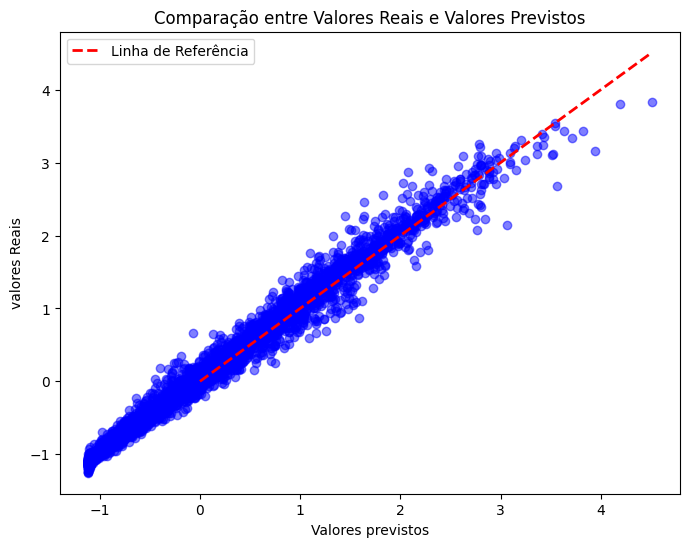

[I 2024-06-30 19:06:18,777] Trial 16 finished with value: 0.018642840906977654 and parameters: {'hidden_dim': 27, 'num_layers': 14, 'learning_rate': 0.00016439174337744798, 'batch_size': 512}. Best is trial 15 with value: 0.013803983107209206.


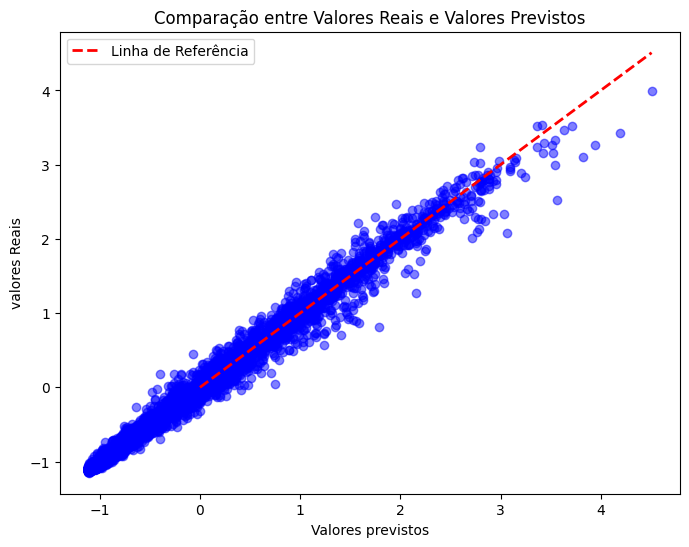

[I 2024-06-30 19:06:33,062] Trial 17 finished with value: 0.015628637745976448 and parameters: {'hidden_dim': 25, 'num_layers': 14, 'learning_rate': 0.00019828533589940793, 'batch_size': 512}. Best is trial 15 with value: 0.013803983107209206.


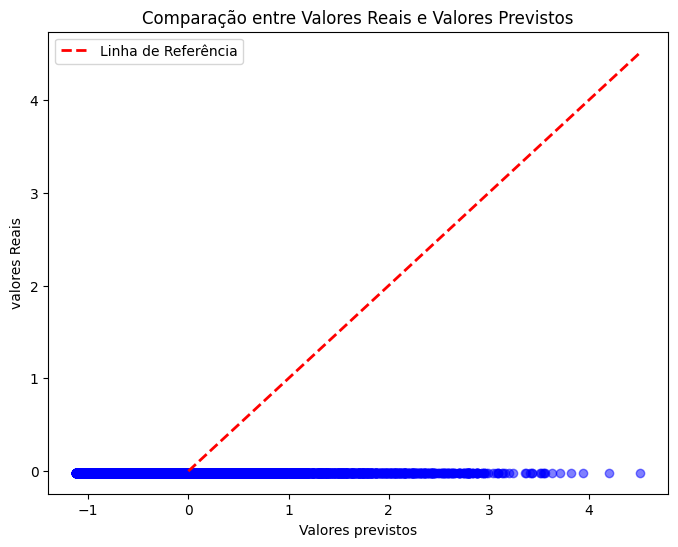

[I 2024-06-30 19:06:54,868] Trial 18 finished with value: 1.0208227634429932 and parameters: {'hidden_dim': 25, 'num_layers': 24, 'learning_rate': 0.0001974360970765182, 'batch_size': 512}. Best is trial 15 with value: 0.013803983107209206.


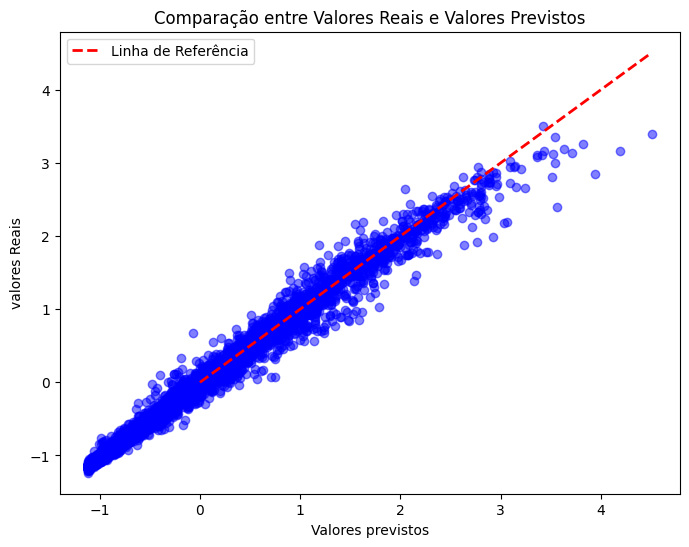

[I 2024-06-30 19:07:10,970] Trial 19 finished with value: 0.017705053091049194 and parameters: {'hidden_dim': 31, 'num_layers': 17, 'learning_rate': 0.00015785007920945571, 'batch_size': 512}. Best is trial 15 with value: 0.013803983107209206.


In [ ]:
input_size = X_train_tensor.shape[1]
print(input_size)

study2 = optuna.create_study(direction='minimize')
train_model = create_train_model(input_size,1,X_train_tensor, joule_train_tensor,X_val_tensor,joule_val_tensor)
study2.optimize(train_model, n_trials=20)

trial = study2.best_trial

In [ ]:
best_model_j = trial.params

best_model = RegressionModel(X_train_tensor.shape[1], best_model_j['hidden_dim'], 1, best_model_j['num_layers'])
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_model_j['learning_rate'])

previstos_j = test(best_model,[X_test_tensor,joule_test_tensor])

for name, param in best_model.named_parameters():
    print(f"{name}: {param.size()}")

print(best_model)

MSE Test Loss: 0.9833
MAE Test Loss: 0.8260
MAPE Test Loss: 1.3623
network.0.weight: torch.Size([26, 11])
network.0.bias: torch.Size([26])
network.2.weight: torch.Size([26, 26])
network.2.bias: torch.Size([26])
network.4.weight: torch.Size([26, 26])
network.4.bias: torch.Size([26])
network.6.weight: torch.Size([26, 26])
network.6.bias: torch.Size([26])
network.8.weight: torch.Size([26, 26])
network.8.bias: torch.Size([26])
network.10.weight: torch.Size([26, 26])
network.10.bias: torch.Size([26])
network.12.weight: torch.Size([26, 26])
network.12.bias: torch.Size([26])
network.14.weight: torch.Size([26, 26])
network.14.bias: torch.Size([26])
network.16.weight: torch.Size([26, 26])
network.16.bias: torch.Size([26])
network.18.weight: torch.Size([26, 26])
network.18.bias: torch.Size([26])
network.20.weight: torch.Size([26, 26])
network.20.bias: torch.Size([26])
network.22.weight: torch.Size([26, 26])
network.22.bias: torch.Size([26])
network.24.weight: torch.Size([26, 26])
network.24.bias

In [ ]:
fine_tune(best_model_j, best_model,5000,optimizer,X_train_tensor,joule_train_tensor,X_val_tensor,joule_val_tensor)
previstos_j = test(best_model, [X_test_tensor, joule_test_tensor])
modeltosave = {'state_dict': best_model.state_dict(),'optimizer':optimizer.state_dict()}
save_model(modeltosave,"nablaj_model.pth")
print(previstos_j)

MSE Test Loss: 0.0048
MAE Test Loss: 0.0363
MAPE Test Loss: 0.2217
salvando modelo...
tensor([[-0.6947],
        [-0.5128],
        [-0.6748],
        ...,
        [-0.9644],
        [-1.1110],
        [-0.9323]], device='cuda:0')


In [ ]:
print('Best trial:')
trial = study2.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value: 0.013803983107209206
  Params: 
    hidden_dim: 26
    num_layers: 14
    learning_rate: 0.0001981005256491448
    batch_size: 512


[I 2024-06-30 19:49:45,247] A new study created in memory with name: no-name-24e7f2b8-e122-4ba5-b559-e691c5acab7d


11


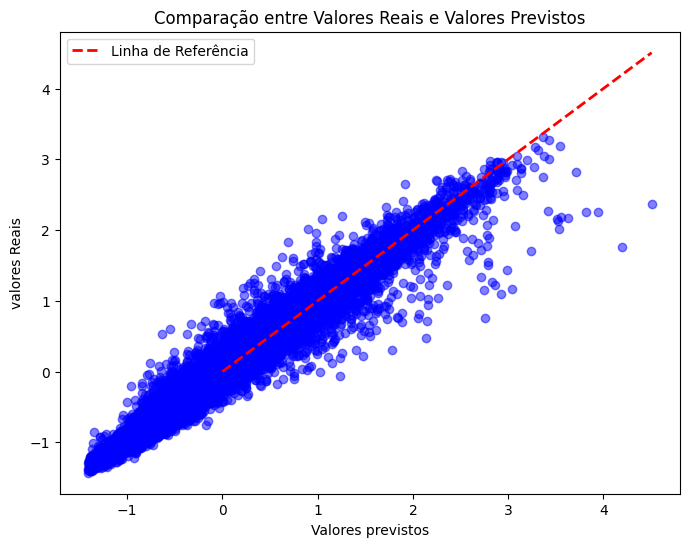

[I 2024-06-30 19:50:03,125] Trial 0 finished with value: 0.05764377862215042 and parameters: {'hidden_dim': 26, 'num_layers': 18, 'learning_rate': 0.00010189420039106942, 'batch_size': 512}. Best is trial 0 with value: 0.05764377862215042.


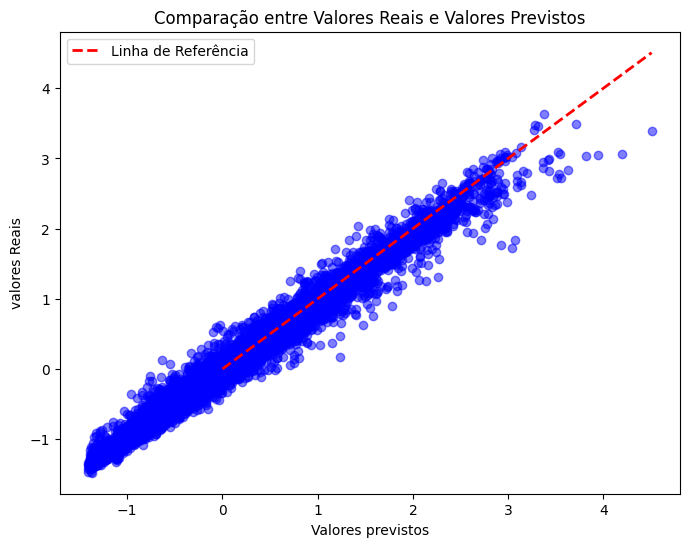

[I 2024-06-30 19:50:19,277] Trial 1 finished with value: 0.02162630669772625 and parameters: {'hidden_dim': 30, 'num_layers': 16, 'learning_rate': 0.0001685456068829817, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


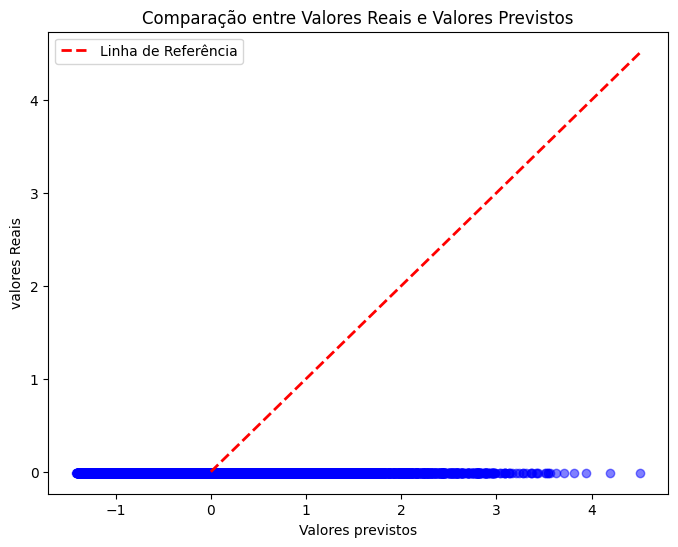

[I 2024-06-30 19:50:41,471] Trial 2 finished with value: 1.0198909044265747 and parameters: {'hidden_dim': 22, 'num_layers': 24, 'learning_rate': 0.00010881723044068177, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


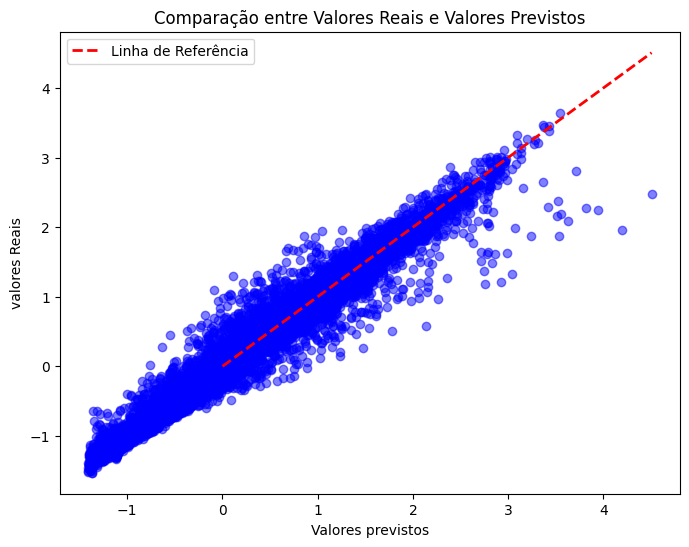

[I 2024-06-30 19:50:51,866] Trial 3 finished with value: 0.04601228982210159 and parameters: {'hidden_dim': 18, 'num_layers': 8, 'learning_rate': 0.0001555127720241457, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


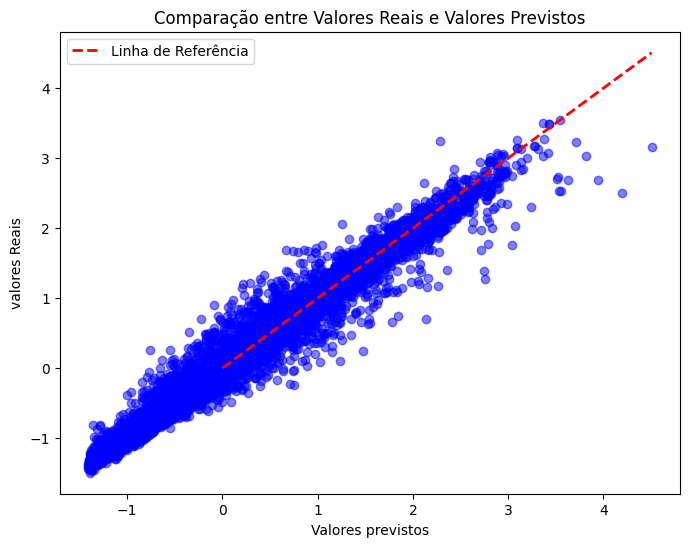

[I 2024-06-30 19:51:05,925] Trial 4 finished with value: 0.035076312720775604 and parameters: {'hidden_dim': 27, 'num_layers': 12, 'learning_rate': 0.00011742986416010399, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


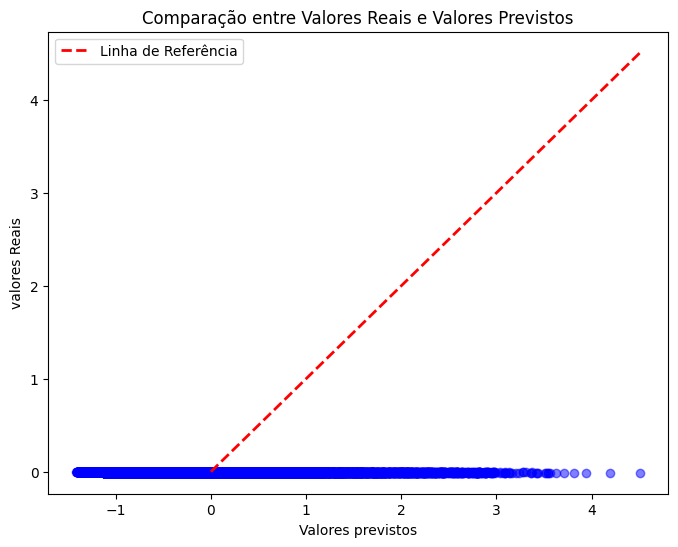

[I 2024-06-30 19:51:29,518] Trial 5 finished with value: 1.0198581218719482 and parameters: {'hidden_dim': 28, 'num_layers': 27, 'learning_rate': 0.00010159092017071489, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


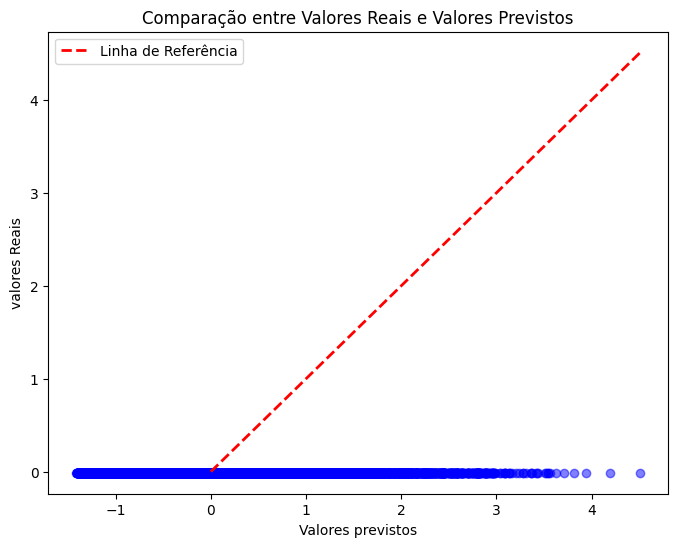

[I 2024-06-30 19:51:52,445] Trial 6 finished with value: 1.0199363231658936 and parameters: {'hidden_dim': 30, 'num_layers': 25, 'learning_rate': 0.00011658488331097053, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


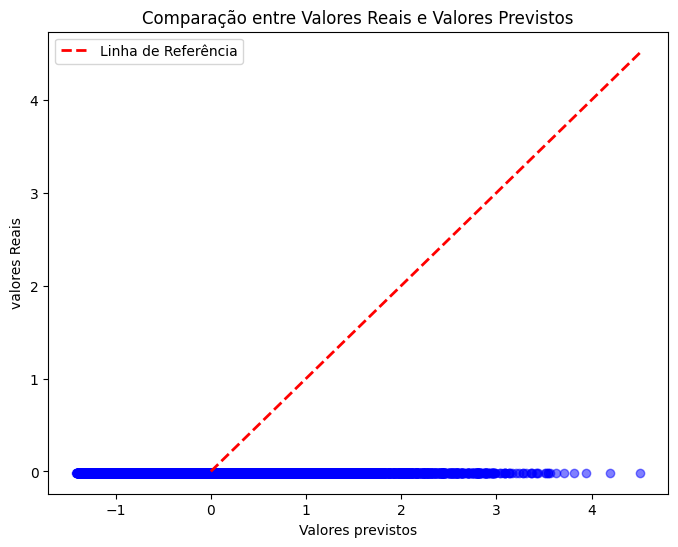

[I 2024-06-30 19:52:17,680] Trial 7 finished with value: 1.0200932025909424 and parameters: {'hidden_dim': 18, 'num_layers': 29, 'learning_rate': 0.00016504831105306123, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


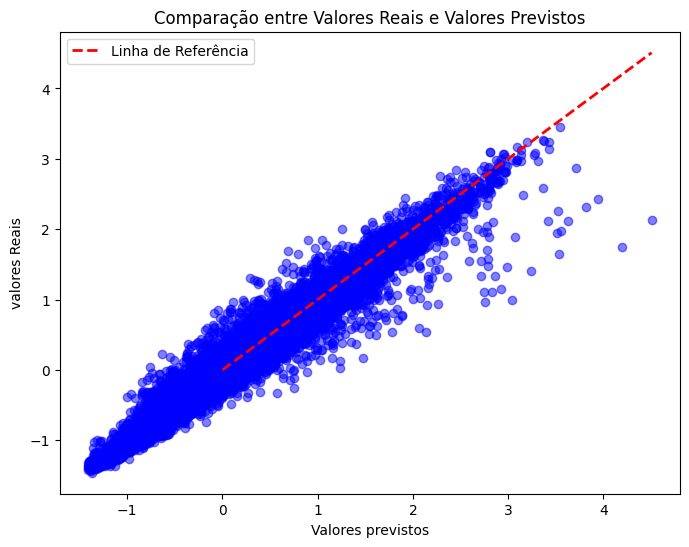

[I 2024-06-30 19:52:36,326] Trial 8 finished with value: 0.05693643540143967 and parameters: {'hidden_dim': 26, 'num_layers': 20, 'learning_rate': 0.00014809124564566626, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


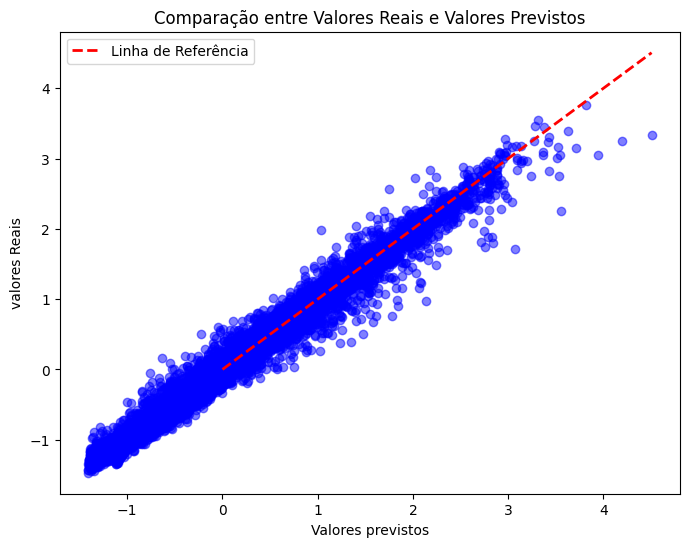

[I 2024-06-30 19:52:50,332] Trial 9 finished with value: 0.02422666922211647 and parameters: {'hidden_dim': 23, 'num_layers': 13, 'learning_rate': 0.00016147266848713123, 'batch_size': 512}. Best is trial 1 with value: 0.02162630669772625.


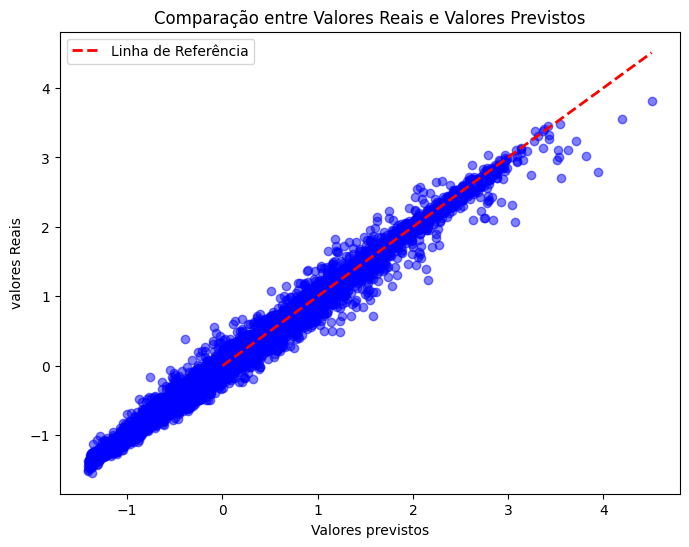

[I 2024-06-30 19:52:59,199] Trial 10 finished with value: 0.01194758154451847 and parameters: {'hidden_dim': 32, 'num_layers': 5, 'learning_rate': 0.00019752803769412317, 'batch_size': 512}. Best is trial 10 with value: 0.01194758154451847.


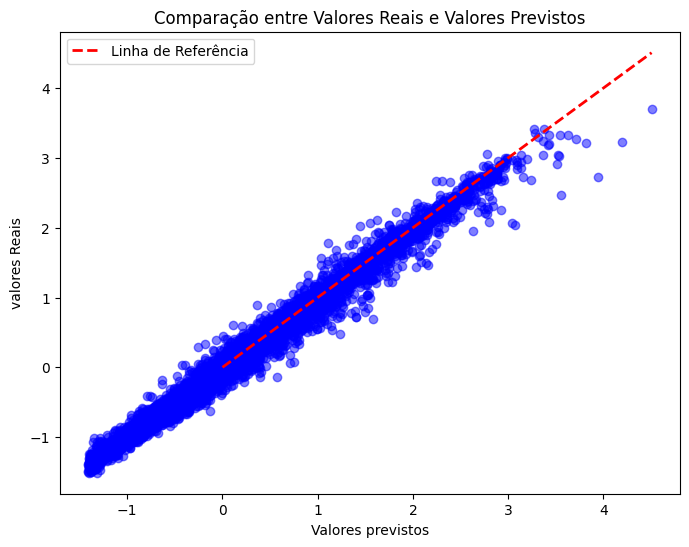

[I 2024-06-30 19:53:09,262] Trial 11 finished with value: 0.01311388611793518 and parameters: {'hidden_dim': 32, 'num_layers': 6, 'learning_rate': 0.00019997067543261527, 'batch_size': 512}. Best is trial 10 with value: 0.01194758154451847.


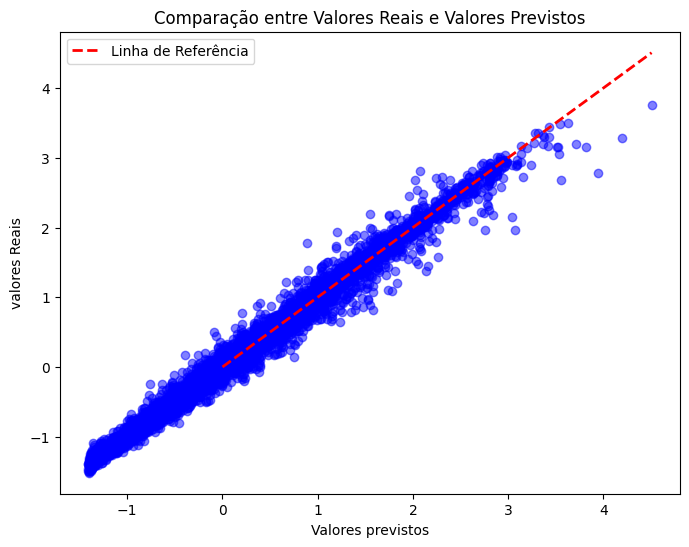

[I 2024-06-30 19:53:17,054] Trial 12 finished with value: 0.01146082766354084 and parameters: {'hidden_dim': 32, 'num_layers': 5, 'learning_rate': 0.0001981539095234157, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


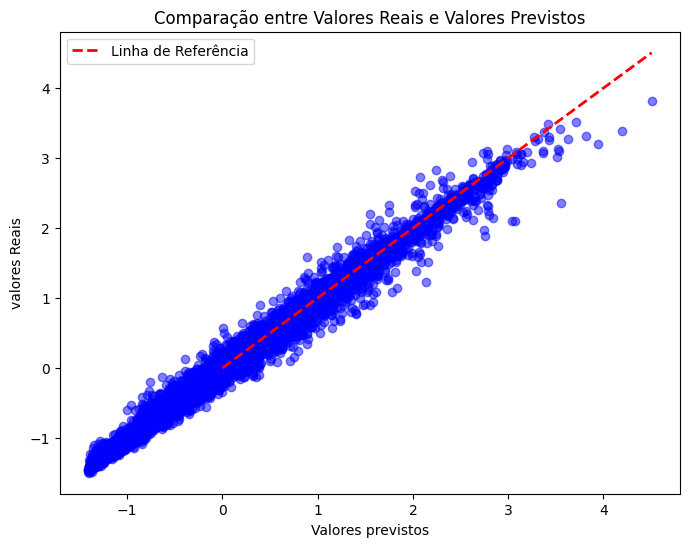

[I 2024-06-30 19:53:28,341] Trial 13 finished with value: 0.013780968263745308 and parameters: {'hidden_dim': 31, 'num_layers': 9, 'learning_rate': 0.00019865062803278876, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


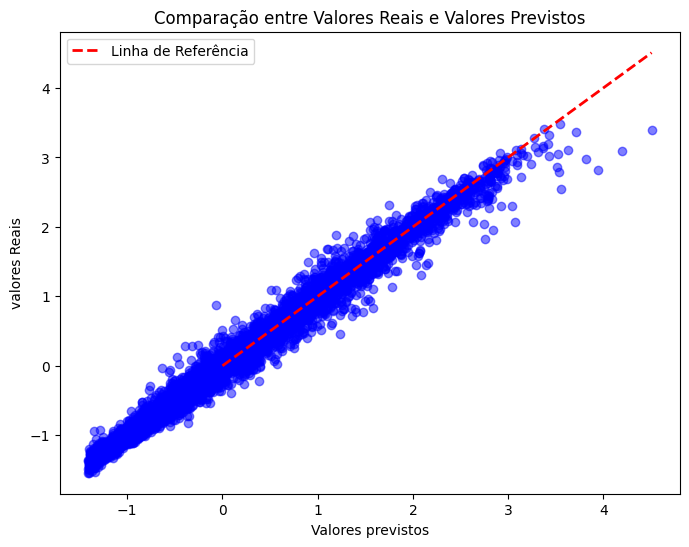

[I 2024-06-30 19:53:37,035] Trial 14 finished with value: 0.015171398408710957 and parameters: {'hidden_dim': 32, 'num_layers': 5, 'learning_rate': 0.00018194267453513778, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


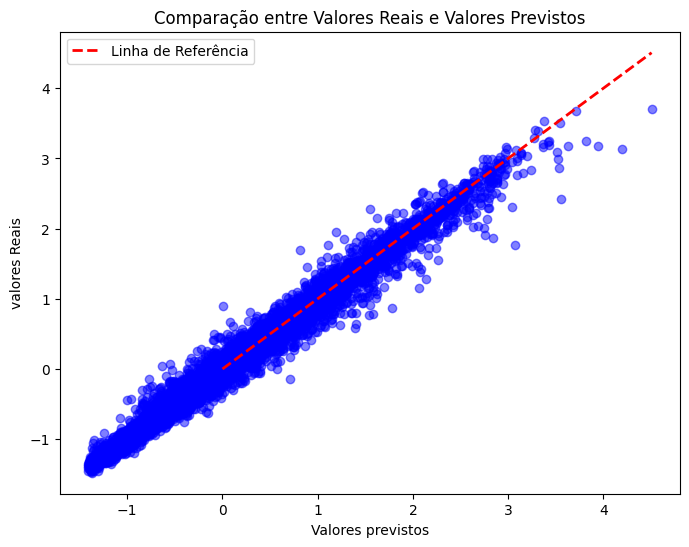

[I 2024-06-30 19:53:49,025] Trial 15 finished with value: 0.017400983721017838 and parameters: {'hidden_dim': 29, 'num_layers': 11, 'learning_rate': 0.00013311769170676574, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


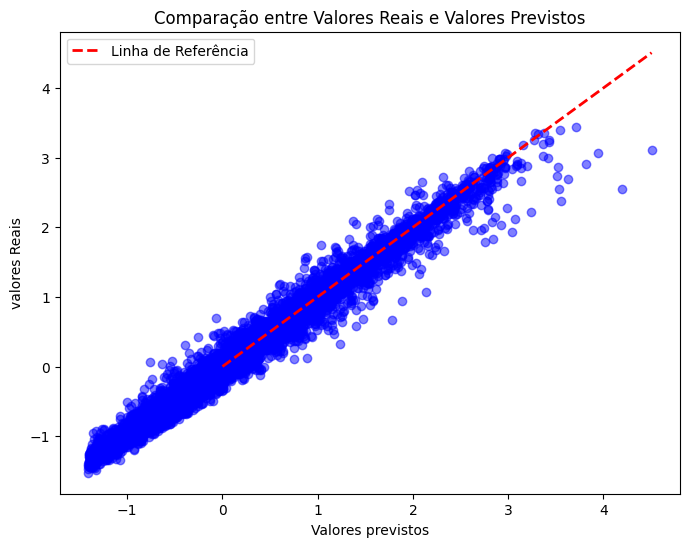

[I 2024-06-30 19:53:56,875] Trial 16 finished with value: 0.021003250032663345 and parameters: {'hidden_dim': 16, 'num_layers': 5, 'learning_rate': 0.0001804814057793861, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


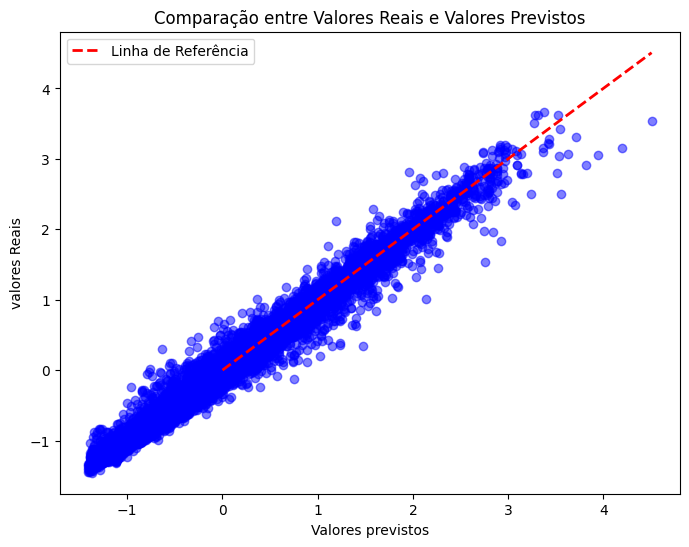

[I 2024-06-30 19:54:11,405] Trial 17 finished with value: 0.02483314275741577 and parameters: {'hidden_dim': 24, 'num_layers': 14, 'learning_rate': 0.00013894516865897564, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


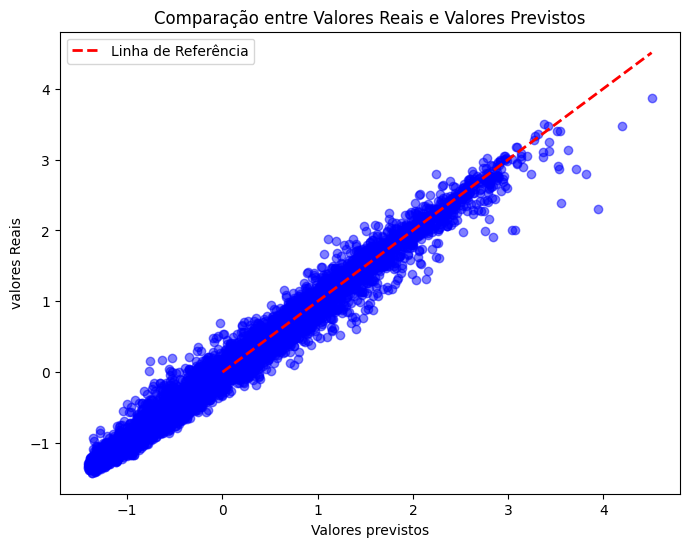

[I 2024-06-30 19:54:22,692] Trial 18 finished with value: 0.01963907852768898 and parameters: {'hidden_dim': 21, 'num_layers': 9, 'learning_rate': 0.0001788225920437748, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


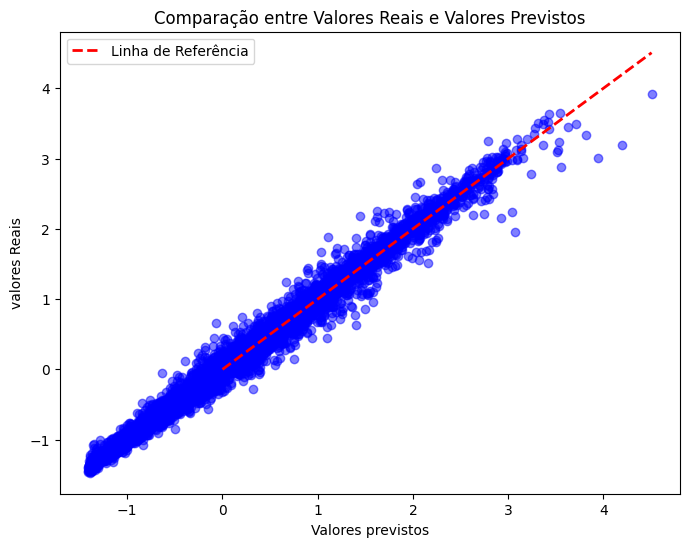

[I 2024-06-30 19:54:32,434] Trial 19 finished with value: 0.012002340517938137 and parameters: {'hidden_dim': 29, 'num_layers': 7, 'learning_rate': 0.00018817974589240287, 'batch_size': 512}. Best is trial 12 with value: 0.01146082766354084.


In [ ]:
input_size = X_train_tensor.shape[1]
print(input_size)

study3 = optuna.create_study(direction='minimize')
train_model = create_train_model(input_size,2,X_train_tensor, y_train_tensor,X_val_tensor,y_val_tensor)
study3.optimize(train_model, n_trials=20)

trial = study3.best_trial

In [ ]:
best_model_t = trial.params

best_model = RegressionModel(X_train_tensor.shape[1], best_model_t['hidden_dim'], 2, best_model_t['num_layers'])
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_model_t['learning_rate'])

previstos_t = test(best_model,[X_test_tensor,y_test_tensor])

for name, param in best_model.named_parameters():
    print(f"{name}: {param.size()}")

print(best_model_t)

MSE Test Loss: 0.9954
MAE Test Loss: 0.8246
MAPE Test Loss: 4.0928
network.0.weight: torch.Size([32, 11])
network.0.bias: torch.Size([32])
network.2.weight: torch.Size([32, 32])
network.2.bias: torch.Size([32])
network.4.weight: torch.Size([32, 32])
network.4.bias: torch.Size([32])
network.6.weight: torch.Size([32, 32])
network.6.bias: torch.Size([32])
network.8.weight: torch.Size([32, 32])
network.8.bias: torch.Size([32])
network.10.weight: torch.Size([2, 32])
network.10.bias: torch.Size([2])
{'hidden_dim': 32, 'num_layers': 5, 'learning_rate': 0.0001981539095234157, 'batch_size': 512}


In [ ]:
fine_tune(best_model_t,best_model,5000,optimizer,X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor)
previstos_t = test(best_model, [X_test_tensor, y_test_tensor])
modeltosave = {'state_dict': best_model.state_dict(),'optimizer':optimizer.state_dict()}
save_model(modeltosave,"nablat_model.pth")
print(previstos_t)

MSE Test Loss: 0.0032
MAE Test Loss: 0.0303
MAPE Test Loss: 0.2825
salvando modelo...
tensor([[-0.4334, -0.6725],
        [-0.4079, -0.5090],
        [-0.2798, -0.6748],
        ...,
        [-0.9441, -0.9688],
        [-1.3883, -1.1166],
        [-1.0902, -0.9611]], device='cuda:0')


In [ ]:
print('Best trial:')
trial = study3.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value: 0.01146082766354084
  Params: 
    hidden_dim: 32
    num_layers: 5
    learning_rate: 0.0001981539095234157
    batch_size: 512


In [ ]:
# Convert tensors to numpy arrays after moving them to the CPU
histeresis_test_np = histeresis_test_tensor.cpu().numpy()
previstos_np_h = previstos_h.cpu().numpy()

mse_h = mean_squared_error(histeresis_test_np, previstos_np_h)
mae_h = mean_absolute_error(histeresis_test_np, previstos_np_h)
mape_h = np.mean(np.abs((histeresis_test_np - previstos_np_h) / histeresis_test_np)) * 100

joule_test_np = joule_test_tensor.cpu().numpy()
previstos_np_j = previstos_j.cpu().numpy()

mse_j = mean_squared_error(joule_test_np, previstos_np_j)
mae_j = mean_absolute_error(joule_test_np, previstos_np_j)
mape_j = np.mean(np.abs((joule_test_np - previstos_np_j) / joule_test_np)) * 100

total_test_np = y_test_tensor.cpu().numpy()
previstos_np_t = previstos_t.cpu().numpy()

mse_t = mean_squared_error(total_test_np, previstos_np_t)
mae_t = mean_absolute_error(total_test_np, previstos_np_t)
mape_t = np.mean(np.abs((total_test_np - previstos_np_t) / total_test_np)) * 100

print(f'V histeresis model:')
print(f'Test MSE: {mse_h}')
print(f'Test MAE: {mae_h}')
print(f'Test MAPE: {mape_h}%')

print(f'V joule model:')
print(f'Test MSE: {mse_j}')
print(f'Test MAE: {mae_j}')
print(f'Test MAPE: {mape_j}%')

print(f'V total model:')
print(f'Test MSE: {mse_t}')
print(f'Test MAE: {mae_t}')
print(f'Test MAPE: {mape_t}%')


V histeresis model:
Test MSE: 0.0017726484220474958
Test MAE: 0.02460244856774807
Test MAPE: 34.132665395736694%
V joule model:
Test MSE: 0.004839570261538029
Test MAE: 0.03634282574057579
Test MAPE: 22.17419594526291%
V total model:
Test MSE: 0.0031677703373134136
Test MAE: 0.030272789299488068
Test MAPE: 28.25223207473755%


MOTOR: V TARGET: hysteresis
Test MSE: 0.0023566479055486924
Test MAE: 0.0327146871090447
Test MAPE: 31.38279694587414%

MOTOR: V TARGET: joule
Test MSE: 0.003373055334037841
Test MAE: 0.03518469037839705
Test MAPE: 29.203365365204526%

MOTOR: V TARGET: total
Test MSE: 0.009457401765956296
Test MAE: 0.062074677843903185
Test MAPE: 13.852825812435348%